## Import Libraries

The iopub_data_rate_limit parameter sets the maximum rate (in bytes per second) at which the Jupyter notebook can send data to the frontend. By default, this value is set to 1e7 (10 MB per second). When you set it to 1e10, you are increasing this limit to 10 GB per second.

In [48]:
import os
os.environ['JUPYTER_ALLOW_INSECURE_WRITES'] = 'true'
os.environ['JUPYTER_RUNTIME_DIR'] = '/tmp'
os.environ['JUPYTER_DATA_DIR'] = '/tmp'
os.environ['JUPYTER_CONFIG_DIR'] = '/tmp'
os.system('jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10')


1

In [49]:
# Ensure this command is executed in an IPython environment (like a Jupyter notebook cell)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Import necessary libraries
import pandas as pd
import os
import sys
import numpy as np

import os
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import hiplot as hip
import matplotlib.pyplot as plt


raw_path = '../../data/raw/'
processed_path = '../../data/processed/'
sys.path.append(raw_path)
sys.path.append(processed_path)

## GMMM and CVAE

### Segment Known Metered Data Using GMM

In [51]:
df_melted = pd.read_csv(processed_path + "df_melted_filtered.csv")

In [52]:
from sklearn.mixture import GaussianMixture
import os
import numpy as np
from sklearn.impute import SimpleImputer
import pandas as pd

In [53]:
df_filtered = df_melted[df_melted['Consumption'] >= 0] # Remove non consumers/generators
df_filtered['Datetime'] = pd.to_datetime(df_filtered['Datetime'])
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Datetime'])

df_filtered.set_index('Datetime', inplace=True)

# Extract the hour of the day from the datetime index
df_filtered['Hour'] = df_filtered.index.hour

# Prepare features for clustering (15-minute interval data)
df_features_15min = df_filtered.groupby(['RND_ID', 'Hour'])['Consumption'].mean().unstack(fill_value=0)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df_features_15min_imputed = pd.DataFrame(imputer.fit_transform(df_features_15min),
                                         index=df_features_15min.index,
                                         columns=df_features_15min.columns)

# Perform Gaussian Mixture Model Clustering on the 15-minute interval data
gmm_15min = GaussianMixture(n_components=5, random_state=42)
df_features_15min_imputed['gmm_cluster'] = gmm_15min.fit_predict(df_features_15min_imputed)

# Extract the segments
df_segments_15min = df_features_15min_imputed[['gmm_cluster']].reset_index()

C:\Users\20235149\AppData\Local\Temp\ipykernel_22200\3798859762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Datetime'] = pd.to_datetime(df_filtered['Datetime'])
C:\Users\20235149\AppData\Local\Temp\ipykernel_22200\3798859762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Datetime'])
C:\Users\20235149\AppData\Local\Temp\ipykernel_22200\3798859762.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [54]:
# Display the resulting segments
df_segments_15min

Hour,RND_ID,gmm_cluster
0,84,4
1,303,2
2,339,4
3,457,3
4,810,0
...,...,...
78,11833,4
79,12050,1
80,12125,3
81,12200,0


### Aggregate to Monthly Data

In [ ]:
# Add time-based features
# Assuming df_filtered is your DataFrame and 'Datetime' column is your datetime index
df_filtered.index = pd.to_datetime(df_filtered.index)  # Ensure index is datetime type
df_filtered.loc[:, 'hour'] = df_filtered.index.hour
df_filtered.loc[:, 'day_of_week'] = df_filtered.index.dayofweek
df_filtered.loc[:, 'month'] = df_filtered.index.month
df_filtered.loc[:, 'is_weekend'] = df_filtered['day_of_week'] >= 5


# Compute monthly total and average consumption
monthly_total = df_filtered.groupby(['RND_ID', 'month'])['Consumption'].sum().reset_index()
monthly_avg = df_filtered.groupby(['RND_ID', 'month'])['Consumption'].mean().reset_index()

# Merge monthly total and average back to the main data
df_filtered = pd.merge(df_filtered, monthly_total, on=['RND_ID', 'month'], suffixes=('', '_monthly_total'))
df_filtered = pd.merge(df_filtered, monthly_avg, on=['RND_ID', 'month'], suffixes=('', '_monthly_avg'))

In [56]:
# Pivot the segments data for faster merging
segments_pivot = df_segments_15min.set_index('RND_ID')['gmm_cluster']

# Map the segments to the monthly data
df_filtered['gmm_cluster'] = df_filtered['RND_ID'].map(segments_pivot)

# Handle cases where the RND_ID might not have a segment assigned
df_filtered = df_filtered.dropna(subset=['gmm_cluster'])


In [57]:
# df_filtered.index = pd.to_datetime(df_filtered.index)  # Ensure index is datetime type

# Assume a subset of the data is unmetered and only pick its monthly consumption
unmetered_rnd_ids = df_filtered['RND_ID'].unique()[:20]
df_unmetered_subset = df_filtered[df_filtered['RND_ID'].isin(unmetered_rnd_ids)]

# Filter out unmetered data from the filtered DataFrame
df_filtered = df_filtered[~df_filtered['RND_ID'].isin(unmetered_rnd_ids)]

# Ensure 'Datetime' is the index for the unmetered subset
# df_unmetered_subset.set_index('Datetime', inplace=True)

# Aggregate the 15-minute interval data to monthly data for unmetered subset
# df_unmetered_subset['Month'] = df_unmetered_subset.index.to_period('M')
# df_unmetered_monthly = df_unmetered_subset.groupby(['RND_ID', 'Month'])['Consumption'].sum().reset_index()

# # Reattach the non-consumption features
# non_consumption_data = df_unmetered_subset[['RND_ID', 'Baseload_profile']].drop_duplicates(subset=['RND_ID'])
# df_unmetered_monthly = df_unmetered_monthly.merge(non_consumption_data, on='RND_ID')

In [58]:
df_filtered

,Unnamed: 0,RND_ID,Baseload_profile,Connection category,Consumption,Timestamp,Hour,hour,day_of_week,month,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,gmm_cluster
1094378,1121280,1501,E3C,AC4A,20.00,2023-01-01 00:00:00,0,0,6,1,True,40276.0,13.533602,0
1094379,1121281,1501,E3C,AC4A,20.00,2023-01-01 00:15:00,0,0,6,1,True,40276.0,13.533602,0
1094380,1121282,1501,E3C,AC4A,20.00,2023-01-01 00:30:00,0,0,6,1,True,40276.0,13.533602,0
1094381,1121283,1501,E3C,AC4A,20.00,2023-01-01 00:45:00,0,0,6,1,True,40276.0,13.533602,0
1094382,1121284,1501,E3C,AC4A,16.00,2023-01-01 01:00:00,1,1,6,1,True,40276.0,13.533602,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434670,4695355,9974,008,AC4B,2.47,2023-12-31 22:45:00,22,22,6,12,True,22137.3,7.438609,0
4434671,4695356,9974,008,AC4B,0.32,2023-12-31 23:00:00,23,23,6,12,True,22137.3,7.438609,0
4434672,4695357,9974,008,AC4B,2.20,2023-12-31 23:15:00,23,23,6,12,True,22137.3,7.438609,0
4434673,4695358,9974,008,AC4B,1.00,2023-12-31 23:30:00,23,23,6,12,True,22137.3,7.438609,0


In [59]:
# # Aggregate the 15-minute interval data to monthly consumption data
# df_monthly_consumption = df_filtered.groupby(['RND_ID', pd.Grouper(freq='M')])['Consumption'].sum().reset_index()

# # Keep only the unique rows for non-consumption data, without indexing on Datetime
# non_consumption_data = df_filtered.reset_index()[['RND_ID', 'Baseload_profile', 'Connection category']].drop_duplicates(subset=['RND_ID'])

# # Merge the monthly consumption data with the non-consumption data on RND_ID
# df_monthly = df_monthly_consumption.merge(non_consumption_data, on='RND_ID', how='left')

# Pivot the segments data for faster merging
segments_pivot = df_segments_15min.set_index('RND_ID')['gmm_cluster']

# Map the segments to the monthly data
df_filtered['gmm_cluster'] = df_filtered['RND_ID'].map(segments_pivot)

# Handle cases where the RND_ID might not have a segment assigned
df_filtered = df_filtered.dropna(subset=['gmm_cluster'])

# Prepare the monthly features for training the GMM prediction model using pivot table
# df_features_monthly = df_filtered.pivot_table(index='RND_ID', columns='gmm_cluster', values='Consumption', aggfunc='mean', fill_value=0).reset_index()

# Display the resulting DataFrame
# print(df_features_monthly.head())


In [60]:
# df_filtered['Month'] = df_filtered['Datetime'].dt.to_period('M')
df_filtered

,Unnamed: 0,RND_ID,Baseload_profile,Connection category,Consumption,Timestamp,Hour,hour,day_of_week,month,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,gmm_cluster
1094378,1121280,1501,E3C,AC4A,20.00,2023-01-01 00:00:00,0,0,6,1,True,40276.0,13.533602,0
1094379,1121281,1501,E3C,AC4A,20.00,2023-01-01 00:15:00,0,0,6,1,True,40276.0,13.533602,0
1094380,1121282,1501,E3C,AC4A,20.00,2023-01-01 00:30:00,0,0,6,1,True,40276.0,13.533602,0
1094381,1121283,1501,E3C,AC4A,20.00,2023-01-01 00:45:00,0,0,6,1,True,40276.0,13.533602,0
1094382,1121284,1501,E3C,AC4A,16.00,2023-01-01 01:00:00,1,1,6,1,True,40276.0,13.533602,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434670,4695355,9974,008,AC4B,2.47,2023-12-31 22:45:00,22,22,6,12,True,22137.3,7.438609,0
4434671,4695356,9974,008,AC4B,0.32,2023-12-31 23:00:00,23,23,6,12,True,22137.3,7.438609,0
4434672,4695357,9974,008,AC4B,2.20,2023-12-31 23:15:00,23,23,6,12,True,22137.3,7.438609,0
4434673,4695358,9974,008,AC4B,1.00,2023-12-31 23:30:00,23,23,6,12,True,22137.3,7.438609,0


In [61]:
### Train a GMM for Segment Prediction

In [62]:
# # Prepare the features for GMM
# X = df_monthly[['Consumption']]

# # Train a GMM on the monthly data
# gmm_monthly = GaussianMixture(n_components=5, random_state=42)
# gmm_monthly.fit(X)

# # Predict the segments for the same data to evaluate (optional)
# df_monthly['predicted_cluster'] = gmm_monthly.predict(X)

In [63]:
df_unmetered_subset = df_unmetered_subset.drop(columns=['Baseload_profile', 'Unnamed: 0','Timestamp','Connection category', 'Hour'])

In [64]:
df_filtered = df_filtered.drop(columns=['Baseload_profile', 'Unnamed: 0','Timestamp','Connection category', 'Hour'])

In [65]:
# df_unmetered_subset = df_unmetered_subset.drop(columns=['Baseload_profile', 'Unnamed: 0','Timestamp','Connection category', 'Hour'])

In [66]:
len(df_filtered['RND_ID'].unique())

63

In [67]:
len(df_unmetered_subset['RND_ID'].unique())

20

In [68]:
df_unmetered_subset

,RND_ID,Consumption,hour,day_of_week,month,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,gmm_cluster
0,10038,8.00,0,6,1,True,32056.00,10.903401,0
1,10038,8.00,0,6,1,True,32056.00,10.903401,0
2,10038,8.00,0,6,1,True,32056.00,10.903401,0
3,10038,8.00,0,6,1,True,32056.00,10.903401,0
4,10038,8.00,1,6,1,True,32056.00,10.903401,0
...,...,...,...,...,...,...,...,...,...
1094373,12893,4.64,22,6,12,True,58475.42,19.648999,3
1094374,12893,4.70,23,6,12,True,58475.42,19.648999,3
1094375,12893,4.50,23,6,12,True,58475.42,19.648999,3
1094376,12893,4.79,23,6,12,True,58475.42,19.648999,3


In [69]:
### Assign Segments to Unmetered Customers

In [70]:
df_filtered

,RND_ID,Consumption,hour,day_of_week,month,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,gmm_cluster
1094378,1501,20.00,0,6,1,True,40276.0,13.533602,0
1094379,1501,20.00,0,6,1,True,40276.0,13.533602,0
1094380,1501,20.00,0,6,1,True,40276.0,13.533602,0
1094381,1501,20.00,0,6,1,True,40276.0,13.533602,0
1094382,1501,16.00,1,6,1,True,40276.0,13.533602,0
...,...,...,...,...,...,...,...,...,...
4434670,9974,2.47,22,6,12,True,22137.3,7.438609,0
4434671,9974,0.32,23,6,12,True,22137.3,7.438609,0
4434672,9974,2.20,23,6,12,True,22137.3,7.438609,0
4434673,9974,1.00,23,6,12,True,22137.3,7.438609,0


In [24]:
df_metered_monthly = df_filtered
del df_filtered
df_unmetered_monthly = df_unmetered_subset
del df_unmetered_subset

In [72]:
# save later
df_metered_monthly.to_csv("df_metered_monthly_100.csv")
df_unmetered_monthly.to_csv("df_unmetered_monthly_100.csv")

## Model Starts Here

In [ ]:
df_metered_monthly = pd.read_csv("df_metered_monthly_100.csv")
df_unmetered_monthly = pd.read_csv("df_metered_monthly_100.csv")

In [24]:
### Train CVAE with Segment Information

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class EnergyDataset(Dataset):
    def __init__(self, data, max_consumption):
        self.data = data
        self.max_consumption = max_consumption

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor([self.data.iloc[idx]['Consumption'] / self.max_consumption], dtype=torch.float32)
        month_numeric = int(self.data.iloc[idx]['month'])
        day_of_week = self.data.iloc[idx]['day_of_week']
        is_weekend = int(self.data.iloc[idx]['is_weekend'])
        Consumption_monthly_avg = self.data.iloc[idx]['Consumption_monthly_avg']
        # rnd_id_numeric = int(self.data.iloc[idx]['RND_ID'])
        c = torch.tensor([month_numeric, day_of_week, is_weekend, Consumption_monthly_avg], dtype=torch.float32) # Remove rnd_id_numeric
        return {'x': x, 'c': c}

# df_unmetered_monthly['month'] = df_unmetered_monthly['month'].dt.to_timestamp().dt.month
# df_metered_monthly['month'] = df_metered_monthly['month'].dt.to_timestamp().dt.month

max_consumption = max(df_metered_monthly['Consumption'].max(), df_unmetered_monthly['Consumption'].max())

unmetered_dataset = EnergyDataset(df_unmetered_monthly, max_consumption)
metered_dataset = EnergyDataset(df_metered_monthly, max_consumption)

train_loader = DataLoader(metered_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(unmetered_dataset, batch_size=32, shuffle=False)

class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + condition_dim, 128)
        self.fc21 = nn.Linear(128, latent_dim)
        self.fc22 = nn.Linear(128, latent_dim)
        self.fc3 = nn.Linear(latent_dim + condition_dim, 128)
        self.fc4 = nn.Linear(128, input_dim)
        self.layer_norm1 = nn.LayerNorm(128)  # Added layer normalization
        self.layer_norm2 = nn.LayerNorm(128)  # Added layer normalization
        self.layer_norm3 = nn.LayerNorm(latent_dim)  # Added layer normalization
        self.layer_norm4 = nn.LayerNorm(128)  # Added layer normalization
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01) #Introduce small weight initializations: To ensure weights start from values that are less likely to explode. We had nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu') before.
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def encode(self, x, c):
        # Encoding the input and condition
        h1 = torch.relu(self.fc1(torch.cat([x, c], dim=1)))
        # print(f"Encode - h1: {h1}")
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        # print(f"Encode - mu: {mu}")
        # print(f"Encode - logvar: {logvar}")
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Clamping logvar to avoid overflow and numerical instability
        logvar_clamped = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar_clamped)
        eps = torch.randn_like(std) * 1e-6  # Added small epsilon for numerical stability
        # print(f"Reparameterize - std: {std}")
        # print(f"Reparameterize - eps: {eps}")
        z = mu + eps * std
        # print(f"Reparameterize - z: {z}")
        return z

    def decode(self, z, c):
        # Decoding the latent variable and condition
        h3 = torch.relu(self.fc3(torch.cat([z, c], dim=1)))
        # recon = torch.relu(self.fc4(h3))
        recon = torch.sigmoid(self.fc4(h3))  # Use sigmoid activation for stability
        # print(f"Decode - h3: {h3}")
        # print(f"Decode - recon: {recon}")
        return recon

    def forward(self, x, c):
        # Forward pass through the network
        # print(f"Input - x: {x}")
        # print(f"Input - c: {c}")
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon, mu, logvar = self.decode(z, c), mu, logvar
        return recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

input_dim = 1
condition_dim = 4
latent_dim = 20 #Increase latent_dim to 50 to capture more information in the latent space.

model = CVAE(input_dim, condition_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x, c = batch['x'], batch['c']
        # print(x,c)
        
        if torch.isnan(x).any() or torch.isnan(c).any():
            print(f"NaN input encountered at epoch {epoch}")
            # print(f"x: {x}")
            # print(f"c: {c}")
            continue
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x, c)
        
#         if torch.isnan(recon_batch).any() or torch.isnan(mu).any() or torch.isnan(logvar).any():
#             print(f"NaN in model output at epoch {epoch}")
#             print(f"recon_batch: {recon_batch}")
#             print(f"mu: {mu}")
#             print(f"logvar: {logvar}")
#             continue
        
        loss = loss_function(recon_batch, x, mu, logvar)
        
        # if torch.isnan(loss).any():
        #     print(f"NaN loss encountered at epoch {epoch}")
        #     print(f"Loss: {loss}")
        #     continue
        
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Clip gradients to prevent exploding gradients
        # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 1, Loss: 0.0007716350878893406
Epoch 2, Loss: 2.922429216238258e-05
Epoch 3, Loss: 1.5668312766568866e-05
Epoch 4, Loss: 1.3311816743119898e-05
Epoch 5, Loss: 1.2231214201032232e-05


MSE: 7.917430380220606, MAE: 2.1115835277947177


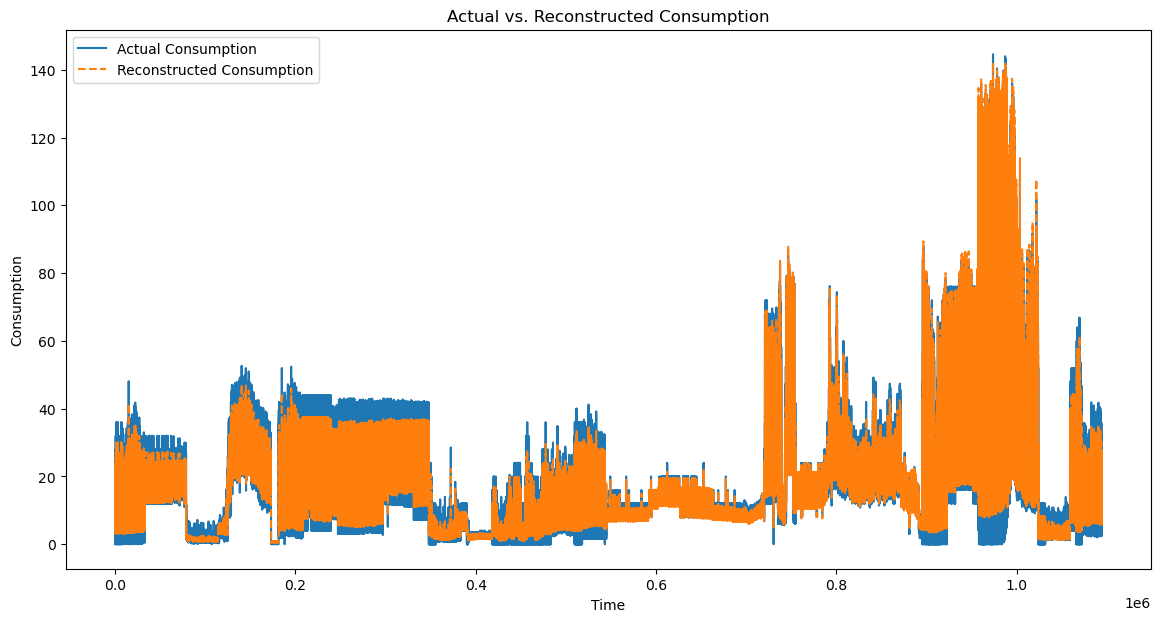

In [30]:
import matplotlib.pyplot as plt

# Testing the model
model.eval()
reconstructed_data = []

with torch.no_grad():
    for batch in test_loader:
        x, c = batch['x'], batch['c']
        recon_batch, mu, logvar = model(x, c)
        recon_batch_original_scale = recon_batch * max_consumption # Add the scale back
        
        # Collect the reconstructed data
        reconstructed_data.append(recon_batch_original_scale.cpu().numpy())

# Convert the list to a NumPy array
reconstructed_data = np.concatenate(reconstructed_data)

# Convert the reconstructed data to a DataFrame
df_reconstructed = pd.DataFrame(reconstructed_data, columns=['Reconstructed_Consumption'])

# Assuming df_unmetered_monthly is your test DataFrame
df_unmetered_monthly['Reconstructed_Consumption'] = df_reconstructed

# If you have the actual 15-minute interval data for comparison
# Here, we assume df_unmetered_monthly has a 'Actual_Consumption' column for comparison
if 'Consumption' in df_unmetered_monthly.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Reconstructed_Consumption']) ** 2).mean()
    mae = (df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Reconstructed_Consumption']).abs().mean()
    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption
    plt.figure(figsize=(14, 7))
    plt.plot(df_unmetered_monthly['Consumption'].values, label='Actual Consumption')
    plt.plot(df_unmetered_monthly['Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.title('Actual vs. Reconstructed Consumption')
    plt.legend()
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")


### With Gaussian Mixed Samplings

In [26]:
# Encode the training data to obtain latent space representations
latent_vectors = []
model.eval()
with torch.no_grad():
    for batch in train_loader:
        x, c = batch['x'], batch['c']
        mu, logvar = model.encode(x, c)
        z = model.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors)

# Fit a Gaussian Mixture Model to the latent space
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=0)
gmm.fit(latent_vectors)

# Use the GMM to sample the latent space during inference
reconstructed_data = []

with torch.no_grad():
    for batch in test_loader:
        c = batch['c']  # Use the conditions for reconstruction
        
        # Sample z from the fitted GMM
        z = gmm.sample(n_samples=c.shape[0])[0]
        z = torch.tensor(z, dtype=torch.float32)
        
        recon_batch = model.decode(z, c)
        recon_batch_original_scale = recon_batch * max_consumption  # Add the scale back
        
        # Collect the reconstructed data
        reconstructed_data.append(recon_batch_original_scale.cpu().numpy())

# Convert the list to a NumPy array
reconstructed_data = np.concatenate(reconstructed_data)

# Convert the reconstructed data to a DataFrame
df_reconstructed = pd.DataFrame(reconstructed_data, columns=['Reconstructed_Consumption'])

# Assuming df_unmetered_monthly is your test DataFrame
df_unmetered_monthly['Reconstructed_Consumption'] = df_reconstructed

MSE: 361.80772399365975, MAE: 13.176629493749571


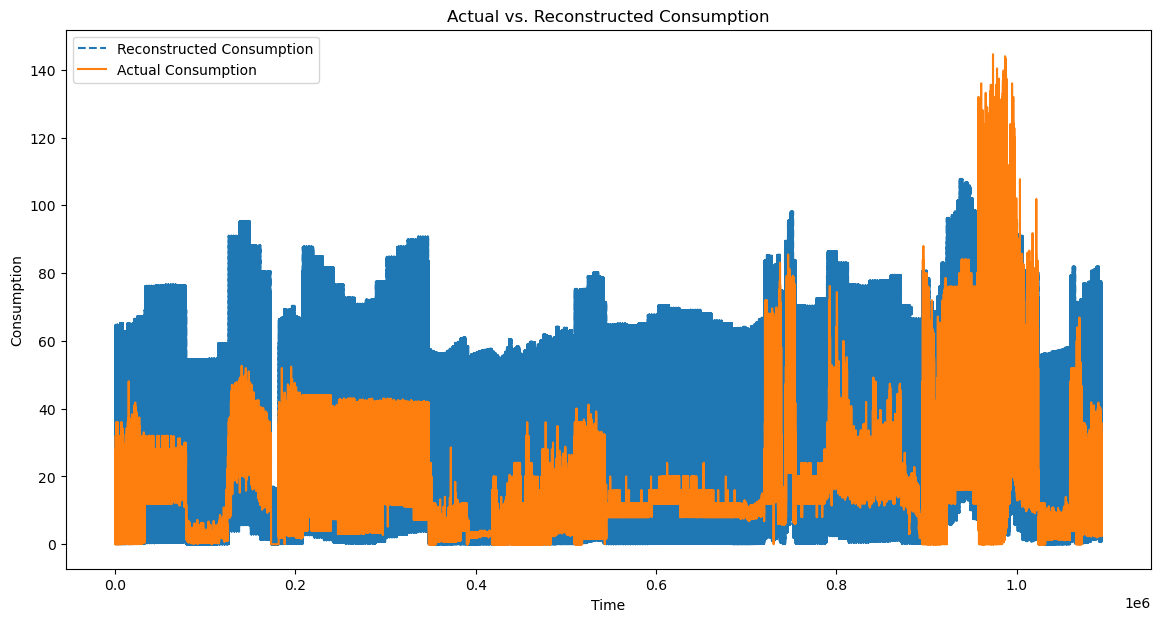

In [31]:
# If you have the actual 15-minute interval data for comparison
# Here, we assume df_unmetered_monthly has a 'Actual_Consumption' column for comparison

# df_unmetered_monthly = df_unmetered_monthly[df_unmetered_monthly['RND_ID']==10038]

if 'Consumption' in df_unmetered_monthly.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Reconstructed_Consumption']) ** 2).mean()
    mae = (df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Reconstructed_Consumption']).abs().mean()
    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption
    plt.figure(figsize=(14, 7))
    plt.plot(df_unmetered_monthly['Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--')
    plt.plot(df_unmetered_monthly['Consumption'].values, label='Actual Consumption')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.title('Actual vs. Reconstructed Consumption')
    plt.legend()
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")

MSE: 424.45832924133254, MAE: 15.727667342597256


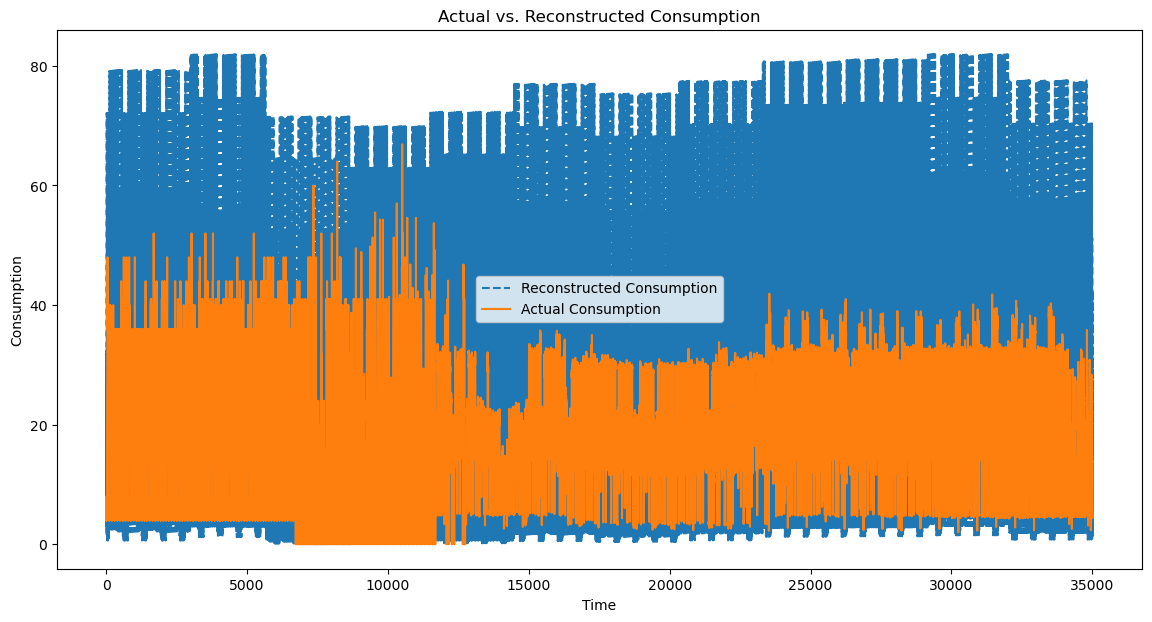

In [30]:
# If you have the actual 15-minute interval data for comparison
# Here, we assume df_unmetered_monthly has a 'Actual_Consumption' column for comparison

df_unmetered_one = df_unmetered_monthly[df_unmetered_monthly['RND_ID']==12893]

if 'Consumption' in df_unmetered_one.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_unmetered_one['Consumption'] - df_unmetered_one['Reconstructed_Consumption']) ** 2).mean()
    mae = (df_unmetered_one['Consumption'] - df_unmetered_one['Reconstructed_Consumption']).abs().mean()
    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption
    plt.figure(figsize=(14, 7))
    plt.plot(df_unmetered_one['Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--')
    plt.plot(df_unmetered_one['Consumption'].values, label='Actual Consumption')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.title('Actual vs. Reconstructed Consumption')
    plt.legend()
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")